In [1]:
import numpy as np
import pandas as pd
import os, tempfile
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from functools import partial

import ray.cloudpickle as pickle
import ray
from ray import train,tune
from ray.train import Checkpoint
from ray.tune.schedulers import ASHAScheduler


In [2]:
print('Cuda is available:',torch.cuda.is_available())
print('Running on device:',torch.cuda.get_device_name(0))
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.empty_cache()

Cuda is available: True
Running on device: NVIDIA GeForce GTX 1060 6GB


## Investigating the Training Data

The Position-Specific Scoring Matrix (PSSM) encodes the likelihood of observing each amino acid at every position within a protein sequence, derived from multiple sequence alignments. In our dataset, the PSSM probability values are already formatted appropriately for training. They span a range from 0 to 1, where 0 indicates no likelihood and 1 signifies absolute likelihood. 

The secondary structure of a protein is influenced by a combination of the amino acid sequence, local interactions, and the overall folding landscape of the protein. Using convolutional layers to assess the local interactions should allow the model to predict the secondry stucture.

In [3]:
single_test = pd.read_csv('test/1A0S_1_P.csv')
single_train = pd.read_csv('train/1A0A_3_A.csv')
print('Length of arbitary test sequence',len(single_test))
print('Length of arbitary train sequence',len(single_train))
single_test

Length of arbitary test sequence 413
Length of arbitary train sequence 63


,RES_NUM,AMINO_ACID,A,C,D,E,F,G,H,I,...,M,N,P,Q,R,S,T,V,W,Y
0,1,S,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000
1,2,G,0.421277,0.0,0.000000,0.000000,0.000000,0.578723,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,3,F,0.000000,0.0,0.000000,0.000000,0.305865,0.000000,0.000000,0.087602,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.316258,0.123237,0.000000
3,4,E,0.018557,0.0,0.303780,0.319588,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.062543,0.0,0.017182,0.0,0.109966,0.091409,0.050172,0.000000,0.000000
4,5,F,0.000000,0.0,0.000000,0.000000,0.749662,0.000000,0.000000,0.000000,...,0.009472,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.098106,0.006089,0.090663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,409,M,0.209190,0.0,0.000000,0.000000,0.132406,0.000000,0.000000,0.022370,...,0.227932,0.000000,0.0,0.000000,0.0,0.018138,0.087666,0.187424,0.045345,0.008464
409,410,E,0.000000,0.0,0.048632,0.903951,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.047416,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
410,411,T,0.338152,0.0,0.000000,0.000000,0.000000,0.000000,0.037084,0.257071,...,0.027027,0.000000,0.0,0.000000,0.0,0.025141,0.164048,0.106223,0.000000,0.045255
411,412,W,0.000000,0.0,0.000000,0.000000,0.015152,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.984848,0.000000


We can see from the data that they are 20 different amino acids for each position in the sequence, we can also observe that the length of the sequences vary between these two arbitary proteins. Diving a bit deeer we can observe that the maximum sequence length for our dataset is 1733.

In [4]:
train_dir = 'train'
line_counts_train = []
test_dir = 'test'
line_counts_test = []

for file_name in os.listdir(train_dir):
    if file_name.endswith('.csv'):
        file_path = os.path.join(train_dir, file_name)
        df = pd.read_csv(file_path)
        line_count = len(df)
        line_counts_train.append(line_count)
        
for file_name in os.listdir(test_dir):
    if file_name.endswith('.csv'):
        file_path = os.path.join(test_dir, file_name)
        df = pd.read_csv(file_path)
        line_count = len(df)
        line_counts_test.append(line_count)

minimum sequence length: 20
maximum sequence length: 1733
max test length: 696
max train length: 1733


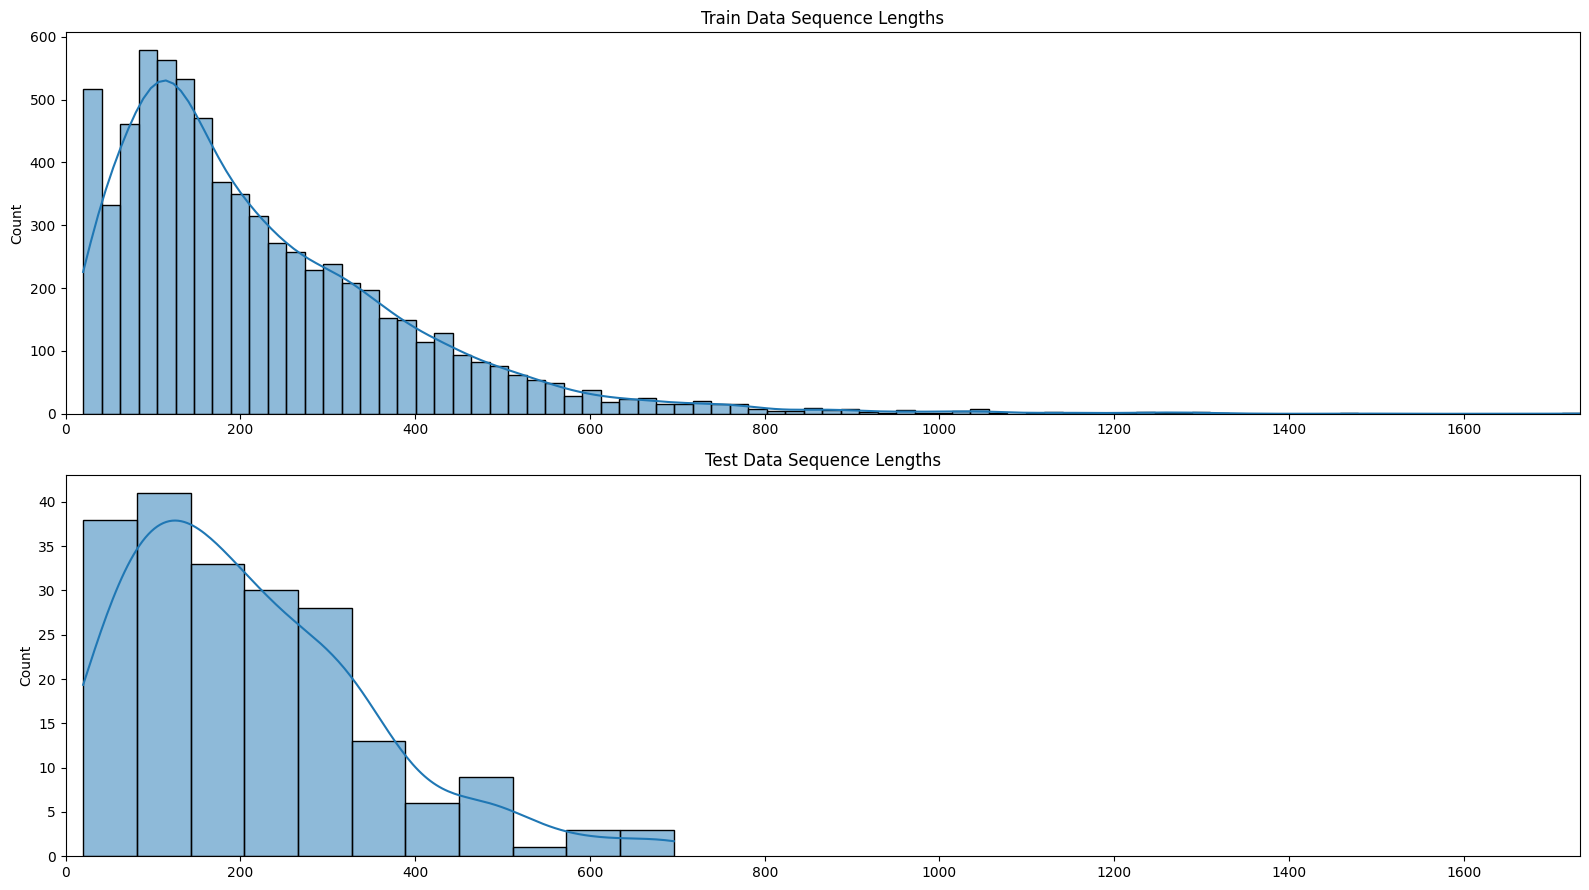

In [5]:
max_sequence_length = max(max(line_counts_train),max(line_counts_test)) 
min_sequence_length = min(min(line_counts_train),min(line_counts_test))

plt.figure(figsize=(16,9))
plt.subplot(2,1,1)
sns.histplot(line_counts_train, kde=True)
plt.xlim(0,max_sequence_length)
plt.title('Train Data Sequence Lengths')
plt.tight_layout()
plt.subplot(2,1,2)
sns.histplot(line_counts_test, kde=True)
plt.xlim(0,max_sequence_length)
plt.title('Test Data Sequence Lengths')
plt.tight_layout()  

print('minimum sequence length:',min_sequence_length)
print('maximum sequence length:',max_sequence_length)
print('max test length:',max(line_counts_test))
print('max train length:',max(line_counts_train))


Normalising both the train and test length to compare distributions

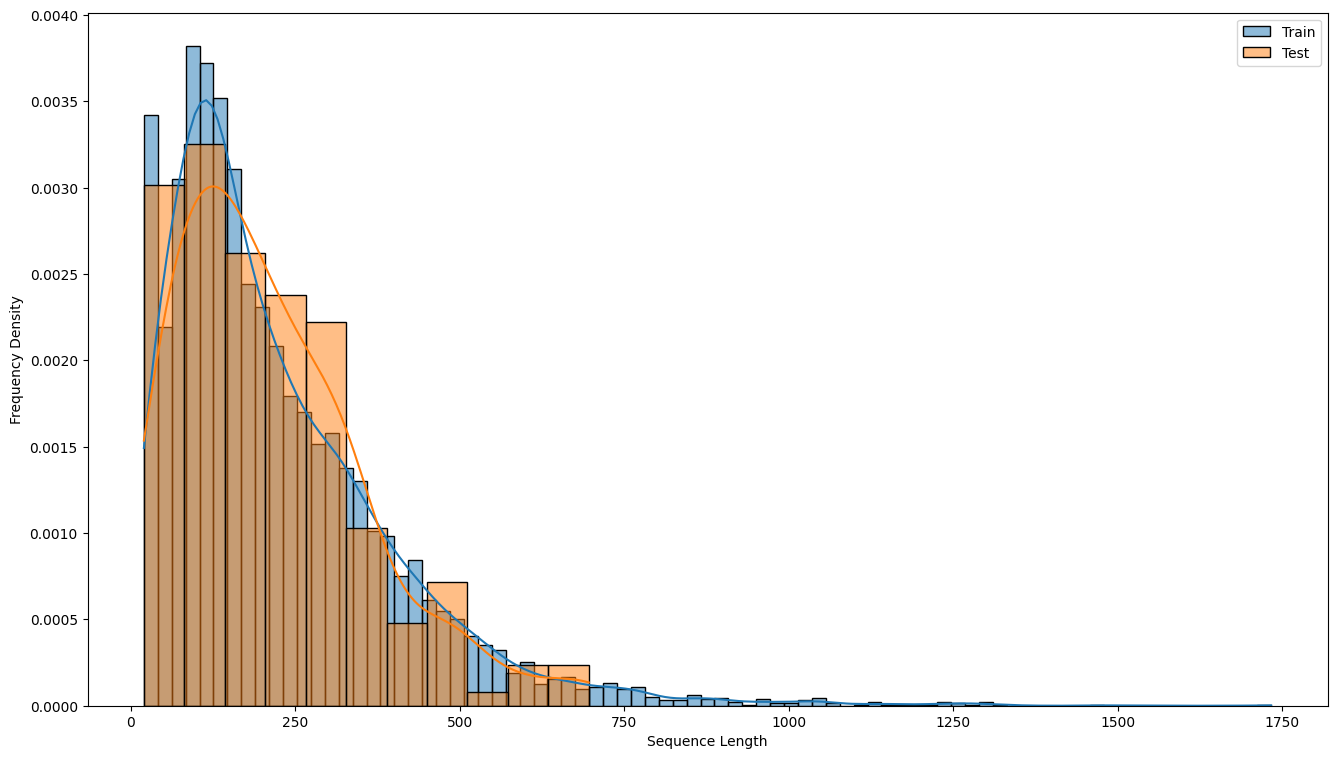

In [6]:
for i in range(0,len(line_counts_train)):
    if i >= len(line_counts_test):
        line_counts_test.append(np.nan)

train_test_df = pd.DataFrame({'train':line_counts_train,'test':line_counts_test})
train_test_df

plt.figure(figsize=(16,9))
sns.histplot(train_test_df['train'],stat='density',kde=True,label='Train')
sns.histplot(train_test_df['test'],stat='density',kde=True,label='Test')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency Density')
plt.legend()


## Initial Processing and Feature Selection

### One hot encode or use probabilities?
In terms of preprocessing for the nueral network, although one hot encoding of the amino acid could be used, as it has the same dimensionality as the probabilities and less information, therefore the probabilities will be used. This will result in a 20 channel (number of different amino acids) by max_sequence_length size input layer. 

i.e shape (N, 20, max_sequence_length) where N is the batch size

### Convolution to observe local interactions
Using a conv1D kernel, the network can hopefully learn what the local interactions between the amino acid percentages signify, before passing the data onto some dense layers.

Finally as the training data is in a different order by PBD_ID to the corresponding labels, i will quickly reorder it to mean that the dataset is simpler to create.

### Removing sequence data after length 750
As making the input layer the max length of the training data would result in an input layer of 1750, instead taking the max length of the train data allows lower computational requirements.

We will experiment to see if accuracy is lost.


In [7]:
max_sequence_length = 750

In [8]:
test_dir = 'test'
train_dir = 'train'


for file_name in os.listdir(test_dir):
    if file_name.endswith('.csv'):
        new_file_name = file_name.replace('_test', '')
        os.rename(os.path.join(test_dir, file_name), os.path.join(test_dir, new_file_name))

for file_name in os.listdir(train_dir):
    if file_name.endswith('.csv'):
        new_file_name = file_name.replace('_train', '')
        os.rename(os.path.join(train_dir, file_name), os.path.join(train_dir, new_file_name))
        


df = pd.read_csv('labels_train.csv')
df_sorted = df.sort_values('PDB_ID')
df_sorted.to_csv('labels_train_sorted.csv', index=False)


One hot encoding the output for training data and creating a reverse

In [9]:
def one_hot_encode_sequence(sequence, max_sequence_length):
    encoding = {'H': [1,0,0,0], 'E': [0,1,0,0], 'C': [0,0,1,0], ' ': [0,0,0,1]}
    encoded_sequence = []

    if len(sequence) > max_sequence_length:
        sequence = sequence[:max_sequence_length]
        
    for char in sequence:
        encoded_sequence.extend(encoding[char])
    
        
    num_blanks = max_sequence_length - len(sequence)
    encoded_sequence.extend([0, 0, 0, 1] * num_blanks)
    
    
    
    return torch.tensor(encoded_sequence, dtype=torch.float32).reshape(-1,4)


def unencode_output(encoded_sequence, threshold=0.5):
    # the encoded_sequence is a N x 4 x L torch.tensor
    
    sequence = ''
    
    for i in range(encoded_sequence.size(1)):  
        
        if encoded_sequence[0,i,0] >= threshold:
            sequence += 'H'
        elif encoded_sequence[0, i, 1] >= threshold:
            sequence += 'E'
        elif encoded_sequence[0, i, 2] >= threshold:
            sequence += 'C'
        else:
            sequence += ' '
    return sequence


test_string = 'HCEC HCCCEC H'
test_encoded = one_hot_encode_sequence(test_string, 5)
print('Original:', test_string)
print('Encoded:', test_encoded)
print('Encoded shape:', test_encoded.shape)
test_encoded.unsqueeze_(0)
print('Decoded:', unencode_output(test_encoded))


Original: HCEC HCCCEC H
Encoded: tensor([[1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])
Encoded shape: torch.Size([5, 4])
Decoded: HCEC 


## Load the data as the PSSM data

We need to load 750 rows of 20 probabilites from the file train

In [23]:
class PSSM_speedy(Dataset):
    """Position-Specific Scoring Matrix (PSSM) Dataset"""

    def __init__(self, pssm_root_dir, sec_struct_file_path, transform=None):
        """
        Args:
            pssm_root_dir (string): Directory with all the protein PSSM data.
            sec_struct_root_dir (string): Directory with all the protein secondary structure data. 
            transform (callable, optional): Optional transform to be applied on a sample. (not used here)           
        """
        self.pssm_root_dir = pssm_root_dir
        self.sec_struct_file_path = sec_struct_file_path
        self.transform = transform
        
        self.file_list = [file for file in os.listdir(pssm_root_dir) if file.endswith('.csv')]
        self.tensor_files_dir = os.path.join(pssm_root_dir, 'tensor_files_750')
        os.makedirs(self.tensor_files_dir, exist_ok=True)

    def preprocess_and_save_tensors(self): # Depending on system requirements may be memory intensive to run
        
        for file_name in self.file_list:
            
            pssm_csv_file = os.path.join(self.pssm_root_dir, file_name)
            pbd_id = os.path.splitext(file_name)[0]
            pbd_id = ''.join(pbd_id)

            pssm_tensor_file_path = os.path.join(self.tensor_files_dir, f"{pbd_id}.pt")
            sec_struct_tensor_file_path = os.path.join(self.tensor_files_dir, f"{pbd_id}_sec_struct.pt")
      
            
            if not os.path.exists(pssm_tensor_file_path):
                pssm_data = pd.read_csv(pssm_csv_file)
                pssm_data = pssm_data.drop(columns=['RES_NUM', 'AMINO_ACID'], axis=1)
                
                num_zeros = 0
                if len(pssm_data) > max_sequence_length:
                    pssm_data = pssm_data[:max_sequence_length]
                else:               
                    num_zeros = max_sequence_length - len(pssm_data)
                if num_zeros > 0:
                    df_zeros = pd.DataFrame(0, index=range(num_zeros), columns=pssm_data.columns)
                    pssm_data = pd.concat([pssm_data, df_zeros], ignore_index=True)
                
                pssm_data = pssm_data.T.to_numpy()
                pssm_data = torch.tensor(pssm_data, dtype=torch.float32)

                torch.save(pssm_data, pssm_tensor_file_path)
            
                
            elif self.sec_struct_file_path is not None:
                if not os.path.exists(sec_struct_tensor_file_path):

                    sec_struct_data = pd.read_csv(self.sec_struct_file_path)
                        
                    sec_struc_value = sec_struct_data.loc[sec_struct_data['PDB_ID'] == pbd_id, 'SEC_STRUCT'].values[0]
                    encoded_sec_struc = one_hot_encode_sequence(sec_struc_value, max_sequence_length)

                    torch.save(encoded_sec_struc, sec_struct_tensor_file_path)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name = self.file_list[idx]
        pbd_id = os.path.splitext(file_name)[0]
        pbd_id = ''.join(pbd_id)
        tensor_file_path = os.path.join(self.tensor_files_dir, f"{pbd_id}.pt")
        pssm_data = torch.load(tensor_file_path)
        input = pssm_data

        
        if self.sec_struct_file_path is not None:

            sec_struct_tensor_file_path = os.path.join(self.tensor_files_dir, f"{pbd_id}_sec_struct.pt")
            encoded_sec_struc = torch.load(sec_struct_tensor_file_path) # form like [[0, 0, 0,1], [0,1,0,0]...]
            target = torch.argmax(encoded_sec_struc,dim=1) # form like [3,1,....]
            return input, target
        
        else:
            return pbd_id,input



speedy_dataset = PSSM_speedy(pssm_root_dir='/home/jamiemilsom/deep_learning/Deep_Learning_MSc/Kaggle/PSSM_Profiles/train',
                      sec_struct_file_path='/home/jamiemilsom/deep_learning/Deep_Learning_MSc/Kaggle/PSSM_Profiles/labels_train.csv')

test_dataset = PSSM_speedy(pssm_root_dir='/home/jamiemilsom/deep_learning/Deep_Learning_MSc/Kaggle/PSSM_Profiles/test',
                      sec_struct_file_path=None)

test_dataset.preprocess_and_save_tensors()
speedy_dataset.preprocess_and_save_tensors()

test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)


train_size = int(0.65 * len(speedy_dataset))
val_size = len(speedy_dataset) - train_size
train_dataset, val_dataset = random_split(speedy_dataset, [train_size, val_size])
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=False)
val_dataloader = DataLoader(val_dataset,batch_size=64, shuffle=False)
train_and_val_dataloader = DataLoader(speedy_dataset,batch_size=64, shuffle=False)

Quickly check the speed to run through a whole epoch with no forward or backward passes

In [24]:
for input, target in train_dataloader:
    continue

## Creating the CNN Structure

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import BatchNorm1d


dropout_prob = 0.5
weight_decay = 2e-3
lr=1e-5
momentum=0
dampening=0
num_classes = 4
max_sequence_length = 750
pssm_input_channels = 20

class ProteinStructurePredictor(nn.Module):
    def __init__(self,dropout_prob,k1,k2,k3,l1,l2,c1,c2,c3,num_classes,max_sequence_length=max_sequence_length): # k = kernel sizes, c = channels,l = linear layers
        super(ProteinStructurePredictor, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=pssm_input_channels, out_channels=c1, kernel_size=k1, padding=((k1-1)//2)), # written long hand first time to help me remeber the order of the arguments
            nn.ReLU(),
            BatchNorm1d(c1),
            nn.Conv1d(c1, c2, kernel_size=k2, padding=((k2-1)//2)),
            nn.ReLU(),
            BatchNorm1d(c2),
            nn.Conv1d(c2, c3, kernel_size=k3, padding=((k3-1)//2)),
            nn.ReLU(),
            BatchNorm1d(c3)
        )
        
        
        self.flatten = nn.Flatten()
        self.fc_layers = nn.Sequential(
            nn.Linear(c3 * max_sequence_length, l1 * max_sequence_length),
            # nn.ReLU(),
            # nn.Dropout(dropout_prob),
            # nn.Linear(l1 * max_sequence_length, l2 * max_sequence_length),
            # nn.ReLU(),
            # nn.Linear(l2 * max_sequence_length, num_classes * max_sequence_length),

        )
        self.max_seq_length = max_sequence_length

    def forward(self, x):
        
        x = self.conv_layers(x)
        
        x = self.flatten(x)
        x = self.fc_layers(x)
        x = x.view(-1, num_classes)
        #x = F.softmax(x, dim=-1) automatically due to Cross Entropy Loss
        return x

model = ProteinStructurePredictor(dropout_prob=dropout_prob,k1=21,k2=9,k3=3,l1=4,l2=4,c1=16,c2=8,c3=4,num_classes=num_classes)
loss_fn = nn.CrossEntropyLoss()
optimizer_conv = torch.optim.Adam(model.parameters(), weight_decay=weight_decay)

print(model)

ProteinStructurePredictor(
  (conv_layers): Sequential(
    (0): Conv1d(20, 16, kernel_size=(21,), stride=(1,), padding=(10,))
    (1): ReLU()
    (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv1d(16, 8, kernel_size=(9,), stride=(1,), padding=(4,))
    (4): ReLU()
    (5): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv1d(8, 4, kernel_size=(3,), stride=(1,), padding=(1,))
    (7): ReLU()
    (8): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_layers): Sequential(
    (0): Linear(in_features=3000, out_features=3000, bias=True)
  )
)


cool ok now they are in the same format :)))

In [26]:
def train_model(model, train_dataloader, val_dataloader, loss_fn, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    model.to(device)
    for epoch in range(num_epochs):
        
        # Training phase
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_dataloader:
            optimizer.zero_grad()
            inputs = inputs.to(device)
            labels = labels.to(device).view(-1)

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()


            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)

            total_train += labels.size(0) - (labels == 3).sum().item()
            
            correct_train += torch.sum((predicted == labels)).item() - (labels == 3).sum().item()

        avg_train_loss = train_loss / len(train_dataloader.dataset)
        train_losses.append(avg_train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device).view(-1)
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)

                total_val += labels.size(0) - (labels == 3).sum().item()
                correct_val += torch.sum((predicted == labels)).item() - (labels == 3).sum().item()

        avg_val_loss = val_loss / len(val_dataloader.dataset)
        val_losses.append(avg_val_loss)
        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
              f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

    return train_losses, val_losses, train_accuracies, val_accuracies

In [27]:
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_dataloader, val_dataloader, loss_fn, optimizer_conv, num_epochs=3)

Epoch [1/3], Train Loss: 0.3867, Train Acc: 0.3978, Val Loss: 0.3604, Val Acc: 0.4625
Epoch [2/3], Train Loss: 0.2907, Train Acc: 0.5841, Val Loss: 0.2806, Val Acc: 0.6021
Epoch [3/3], Train Loss: 0.2653, Train Acc: 0.6307, Val Loss: 0.2696, Val Acc: 0.6309


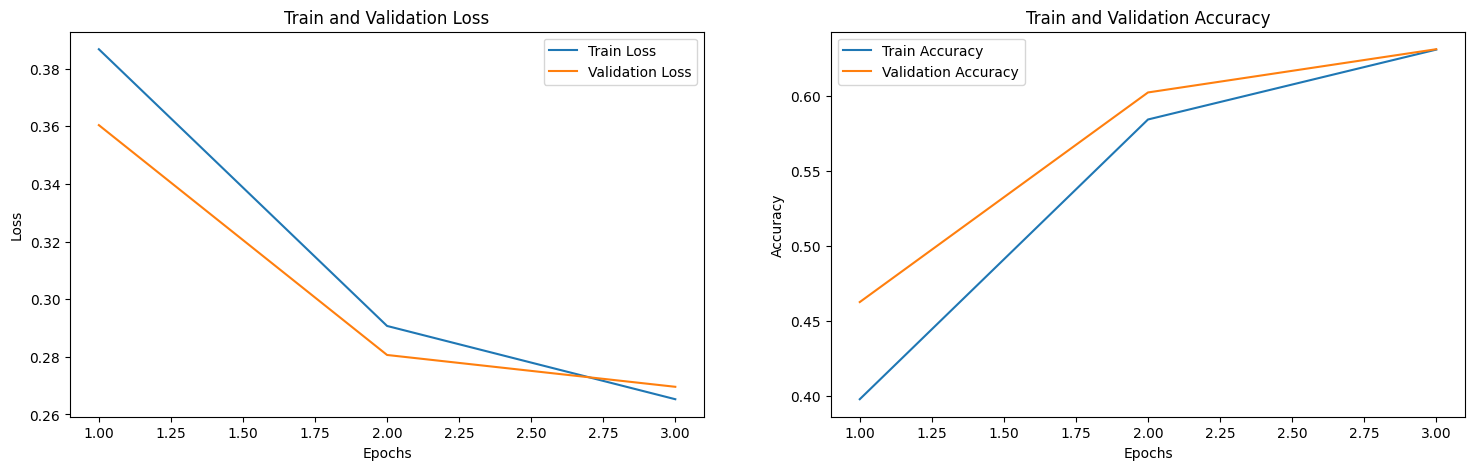

In [28]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize = (18,5))
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()


plt.subplot(1,2,2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()


Implementing Raytune

In [16]:
context = ray.init()
print(context.dashboard_url)

2024-02-29 01:39:34,298	INFO worker.py:1724 -- Started a local Ray instance.


In [17]:
def train_model_raytune(config):
    model = ProteinStructurePredictor(dropout_prob=config["dropout_prob"],k1=config["k1"],k2=config["k2"],k3=config["k3"],l1=config["l1"],l2=config["l2"],c1=config["c1"],c2=config["c2"],c3=config["c3"],num_classes=4)

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=config["weight_decay"])

    checkpoint = train.get_checkpoint()

    if checkpoint:
        with train.get_checkpoint().as_directory() as checkpoint_dir:
          with open(os.path.join(checkpoint_dir, 'data.pkl'), 'rb') as fp:
            checkpoint_state = pickle.load(fp)
            start_epoch = checkpoint_state["epoch"]
            model.load_state_dict(checkpoint_state["model_state_dict"])
            optimizer.load_state_dict(checkpoint_state["optimizer_state_dict"])
    else:
        start_epoch = 0

    train_subset, val_subset = train_dataset, val_dataset


    trainloader = torch.utils.data.DataLoader(
        train_subset, batch_size=int(config["batch_size"]), shuffle=False, num_workers=8
    )
    valloader = torch.utils.data.DataLoader(
        val_subset, batch_size=int(config["batch_size"]), shuffle=False, num_workers=8
    )
    max_accuracy = 0

    for epoch in range(start_epoch, start_epoch + config["num_epochs"]):
        running_loss = 0.0
        epoch_steps = 0
        total_train = 0
        correct_train = 0
        
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device).view(-1)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            total_train += labels.size(0) - (labels == 3).sum().item()
            correct_train += torch.sum((predicted == labels)).item() - (labels == 3).sum().item()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item() * inputs.size(0) # maybe change this to just loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print(
                    "[%d, %5d] loss: %.3f"
                    % (epoch + 1, i + 1, running_loss / epoch_steps)
                )
                running_loss = 0.0
                

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device).view(-1)

                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                
                total += labels.size(0)- (labels == 3).sum().item()
                correct += torch.sum((predicted == labels)).item() - (labels == 3).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy() * inputs.size(0)
                val_steps += 1


        checkpoint_data = {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        }

        """
        with tempfile.TemporaryDirectory() as checkpoint_dir:
            with open(os.path.join(checkpoint_dir, 'data.pkl'), 'wb') as fp:
                pickle.dump(checkpoint_data, fp)                
        
                
        checkpoint = Checkpoint.from_directory(checkpoint_dir)
        """
        if correct / total > max_accuracy:
            max_accuracy = correct / total
        train.report(
              {"epochs":epoch,"loss": val_loss / val_steps, "test accuracy":correct_train/total_train,"val accuracy": correct / total, 'max accuracy':max_accuracy})#,
              #checkpoint=checkpoint,
          #)
    print("Finished Training")

In [18]:

def test_accuracy(model, device=device):
    trainset, testset = test_dataset, val_dataset

    testloader = torch.utils.data.DataLoader(
        testset, batch_size=32, shuffle=False, num_workers=2
    )

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            input, labels = data
            input, labels = input.to(device), labels.to(device)
            outputs = model(input)
            
            _, predicted = torch.max(outputs, 1)
            
            total += labels.size(0) - (labels == 3).sum().item()
            correct += torch.sum((predicted == labels)).item() - (labels == 3).sum().item()

    return correct / total

In [19]:
def main(num_samples=10, max_num_epochs=50, gpus_per_trial=1):

    config = {
        "l1": tune.choice([4]),
        "l2": tune.choice([4]),
        "dropout_prob": tune.choice([0]),
        "k1": tune.choice([15, 21]),
        "k2": tune.choice([9, 15]),
        "k3": tune.choice([5, 9, 15]),
        "c1": tune.choice([16, 32]),
        "c2": tune.choice([16, 32]),
        "c3": tune.choice([4, 8, 16]),
        "batch_size": tune.choice([64]),
        "weight_decay": tune.loguniform(5e-4, 5e-3),
        "num_epochs": max_num_epochs,
    }
    scheduler = ASHAScheduler(
        metric="val accuracy",
        mode="max",
        max_t=max_num_epochs,
        grace_period=15,
        reduction_factor=2,
    )

    result = tune.run(
        train_model_raytune,
        resources_per_trial={"cpu": 3, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        max_concurrent_trials=5,
    )
    
    """
    best_trial = result.get_best_trial("accuracy", "max", "last")
    print(f"Best trial config: {best_trial.config}")
    print(f"Best trial final validation loss: {best_trial.last_result['loss']}")
    print(f"Best trial final validation accuracy: {best_trial.last_result['accuracy']}")

    best_trained_model = ProteinStructurePredictor(best_trial.config["dropout_prob"],best_trial.config["k1"],best_trial.config["k2"],best_trial.config["k3"],best_trial.config["l1"],best_trial.config["c1"],best_trial.config["c2"],best_trial.config["c3"],num_classes=4)
    return best_trained_model
    
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if gpus_per_trial > 1:
            best_trained_model = nn.DataParallel(best_trained_model)
    best_trained_model.to(device)

    best_checkpoint = best_trial.checkpoint;

    if best_checkpoint:
        with best_checkpoint.as_directory() as checkpoint_dir:
          with open(os.path.join(checkpoint_dir, 'data.pkl'), 'rb') as fp:
            best_checkpoint_data = pickle.load(fp)
            best_trained_model.load_state_dict(best_checkpoint_data["model_state_dict"])
            test_acc = test_accuracy(best_trained_model, device)
            print("Best trial test set accuracy: {}".format(test_acc))

    """

if __name__ == "__main__":

    best_trained_model = main(num_samples=20, max_num_epochs=100, gpus_per_trial=0.2)

2024-02-29 01:39:35,171	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Trial name,epochs,loss,max accuracy,test accuracy,val accuracy
train_model_raytune_64a9c_00000,99,15.4344,0.665118,0.679487,0.664016
train_model_raytune_64a9c_00001,99,15.036,0.676229,0.69748,0.675992
train_model_raytune_64a9c_00002,99,15.2713,0.681398,0.722567,0.677461
train_model_raytune_64a9c_00003,14,17.2397,0.653157,0.800495,0.6463
train_model_raytune_64a9c_00004,59,16.3823,0.669509,0.799527,0.663868
train_model_raytune_64a9c_00005,14,16.3137,0.6489,0.659367,0.6489
train_model_raytune_64a9c_00006,14,18.851,0.629329,0.799384,0.623733
train_model_raytune_64a9c_00007,99,15.2035,0.678354,0.706598,0.675137
train_model_raytune_64a9c_00008,29,16.3042,0.673,0.779612,0.657517
train_model_raytune_64a9c_00009,99,15.7072,0.687762,0.800052,0.679356


2024-02-29 02:12:33,338	INFO tune.py:1042 -- Total run time: 1978.17 seconds (1978.11 seconds for the tuning loop).


Training on both joint train and validation

In [108]:
best_trained_model = ProteinStructurePredictor(0,15,9,5,4,4,32,16,4,4)
optimizer_conv = torch.optim.Adam(best_trained_model.parameters(), weight_decay=0.0016)
train_losses, val_losses, train_accuracies, val_accuracies = train_model(best_trained_model, train_and_val_dataloader, val_dataloader, loss_fn, optimizer_conv, num_epochs=20)

Epoch [1/20], Train Loss: 0.3423, Train Acc: 0.4848, Val Loss: 0.2487, Val Acc: 0.6591
Epoch [2/20], Train Loss: 0.2559, Train Acc: 0.6454, Val Loss: 0.2340, Val Acc: 0.6839
Epoch [3/20], Train Loss: 0.2423, Train Acc: 0.6684, Val Loss: 0.2295, Val Acc: 0.6900
Epoch [4/20], Train Loss: 0.2368, Train Acc: 0.6788, Val Loss: 0.2121, Val Acc: 0.7209
Epoch [5/20], Train Loss: 0.2333, Train Acc: 0.6852, Val Loss: 0.2093, Val Acc: 0.7284
Epoch [6/20], Train Loss: 0.2305, Train Acc: 0.6903, Val Loss: 0.2062, Val Acc: 0.7307
Epoch [7/20], Train Loss: 0.2279, Train Acc: 0.6944, Val Loss: 0.2084, Val Acc: 0.7302
Epoch [8/20], Train Loss: 0.2258, Train Acc: 0.6978, Val Loss: 0.2038, Val Acc: 0.7310
Epoch [9/20], Train Loss: 0.2240, Train Acc: 0.7003, Val Loss: 0.2052, Val Acc: 0.7293
Epoch [10/20], Train Loss: 0.2225, Train Acc: 0.7026, Val Loss: 0.2031, Val Acc: 0.7315
Epoch [11/20], Train Loss: 0.2213, Train Acc: 0.7045, Val Loss: 0.2032, Val Acc: 0.7330
Epoch [12/20], Train Loss: 0.2202, Train 

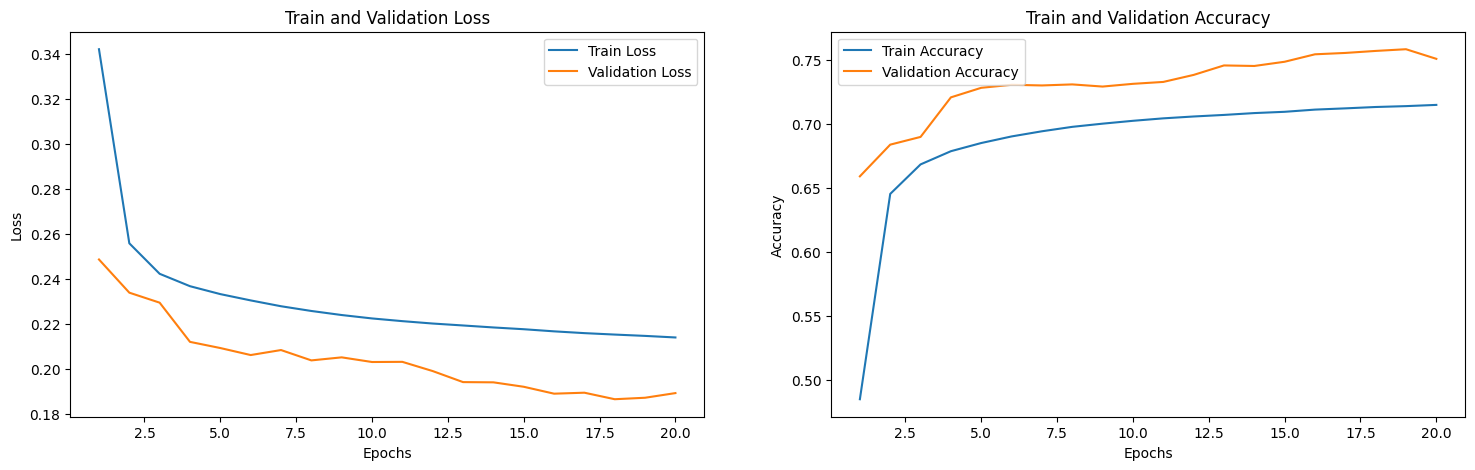

In [116]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize = (18,5))
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()


plt.subplot(1,2,2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()


In [117]:
all_outputs = []
all_pbids = []

model.eval()
model.to(device)
val_loss = 0.0
correct_val = 0
total_val = 0
with torch.no_grad():
    for pbid, inputs in test_dataloader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        all_pbids.extend(pbid)
        all_outputs.append(outputs)
all_outputs_tensor = torch.cat(all_outputs, dim=0)


In [118]:
print(all_outputs_tensor.shape)
print(all_outputs_tensor[0,:])

torch.Size([153750, 4])
tensor([-1.1521, -1.0778,  3.7717, -1.1411], device='cuda:0')


In [119]:
def unencode_output(encoded_sequence, threshold=0.5):
    # the encoded_sequence is a N X L X 4 torch.tensor
    
    sequence = ''
    
    for i in range(encoded_sequence.size(0)):  
        
        if encoded_sequence[i,0] >= threshold:
            sequence += 'H'
        elif encoded_sequence[i, 1] >= threshold:
            sequence += 'E'
        elif encoded_sequence[i, 2] >= threshold:
            sequence += 'C'
        else:
            sequence += 'C'
    return sequence

In [120]:
def count_rows_in_file(file_path):
    with open(file_path, 'r') as f:
        # Count the number of lines in the file
        count = sum(1 for line in f)
    return count

In [121]:
def create_submission(pbids, output_tensors, output_file):
    with open(output_file, 'w') as f:
        f.write("ID,STRUCTURE\n")
        for i, pbid in enumerate(pbids):
            output = output_tensors[max_sequence_length * i:max_sequence_length * (i+2),:]
            sequence = unencode_output(output)

            for j in range(count_rows_in_file('test/' + pbid + '.csv') - 1):
                f.write(f"{pbid}_{j+1},{sequence[j]}\n")


output_file = "submission.csv"
create_submission(all_pbids, all_outputs_tensor.cpu(), output_file)


The file should be 43161 + header

In [122]:
submission_file = "submission.csv"
num_rows = count_rows_in_file(submission_file)
print("Number of rows in the submission file:", num_rows)


Number of rows in the submission file: 43162
